In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/my-files/projects/yem
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n%cd /content/drive/MyDrive/my-files/projects/yem\n"

In [1]:
##############
## INITIATE ##
##############

## Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import yaml

## Import modules
from f_YEM_V1_14_2025_10_10 import pdf
from f_YEM_V1_14_2025_10_10 import f_normal
from f_YEM_V1_14_2025_10_10 import YellowstoneEcosystemModel
from f_YEM_V1_14_2025_10_10 import plot_model

## Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu" # Force cpu for now
print(device)

## Figure parameters
plt.rcParams['figure.dpi'] = 100
FIGSIZE = (6,4)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.facecolor':'whitesmoke'}
sns.set_theme(style="ticks", rc=custom_params)

## Font
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

#
###

cpu


In [2]:
####################
## INITIATE MODEL ##
####################

## Model
model = YellowstoneEcosystemModel("parameters-aposteriori-V1-14-2025-10-13.yaml")

#
###

In [3]:
#####################################
## INITIATE EXTIRPATION EXPERIMENT ##
#####################################

## Initiate parameters
t_max_0 = 200
t_max_1 = 200
t_max_2 = 200
t_max_3 = 200

## Hyperparameters
INITIAL_BIOMASS = 15.0
ZZZ_LEN = 200
ZZMAX = [100, 100, 500, 1000, 200, 300]

## Period 0
t0 = time.time()
predictions_0 = model.simulate(t_max=t_max_0,
                             Dt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Bt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Pt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             Gt = torch.tensor(INITIAL_BIOMASS*1e9, dtype=torch.float64),
                             NNt = torch.tensor([1*100, 1*100, 1*1000, 1*1000, 1*100, 1*100], dtype=torch.float64),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
tf = time.time()
print(f"{tf-t0:.2f}s")

## Save initial conditions
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_0
Dt_0 = DDt[-1].clone().detach()
Bt_0 = BBt[-1].clone().detach()
Pt_0 = PPt[-1].clone().detach()
Gt_0 = GGt[-1].clone().detach()
NNt_0 = NNNt[-1].clone().detach()
NNNzt_0 = NNNNzt[-1].clone().detach()

#
###

3.79s


In [4]:
################################
## RUN EXTIRPATION EXPERIMENT ##
################################

## Period 1
t0 = time.time()
predictions_1 = model.simulate(t_max=t_max_1,
                             Dt = Dt_0,
                             Bt = Bt_0,
                             Pt = Pt_0,
                             Gt = Gt_0,
                             NNt = NNt_0,
                             NNNzt = NNNzt_0,
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_1
tf = time.time()
print(f"{tf-t0:.2f}s")

## Extirpate wolves and cougars
NNt_1 = NNNt[-1].clone().detach()
NNNzt_1 = NNNNzt[-1].clone().detach()
#
## Wolves
NNt_1[4] *= torch.tensor(0.0, dtype=torch.float64)
NNNzt_1[4] *= torch.tensor(0.0, dtype=torch.float64)
#
## Cougars
NNt_1[5] *= torch.tensor(0.0, dtype=torch.float64)
NNNzt_1[5] *= torch.tensor(0.0, dtype=torch.float64)

## Period 2
t0 = time.time()
predictions_2 = model.simulate(t_max=t_max_2,
                             Dt = DDt[-1].clone().detach(),
                             Bt = BBt[-1].clone().detach(),
                             Pt = PPt[-1].clone().detach(),
                             Gt = GGt[-1].clone().detach(),
                             NNt = NNt_1.clone().detach(),
                             NNNzt = NNNzt_1.clone().detach(),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_2
tf = time.time()
print(f"{tf-t0:.2f}s")

## Re-introduce wolves and cougars
NNt_2 = NNNt[-1].clone().detach()
NNNzt_2 = NNNNzt[-1].clone().detach()
#
## Wolves
N_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_mean_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_std_introduced = torch.tensor(3.0, dtype=torch.float64)
NNt_2[4] = N_introduced.clone().detach()
NNNzt_2[4] = (N_introduced * pdf(f_normal(zzz[4].clone().detach(), Z_mean_introduced, Z_std_introduced))).clone().detach()
#
## Cougars
N_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_mean_introduced = torch.tensor(30.0, dtype=torch.float64)
Z_std_introduced = torch.tensor(3.0, dtype=torch.float64)
NNt_2[5] = N_introduced.clone().detach()
NNNzt_2[5] = (N_introduced * pdf(f_normal(zzz[5].clone().detach(), Z_mean_introduced, Z_std_introduced))).clone().detach()

## Period 3
t0 = time.time()
predictions_3 = model.simulate(t_max=t_max_3,
                             Dt = DDt[-1].clone().detach(),
                             Bt = BBt[-1].clone().detach(),
                             Pt = PPt[-1].clone().detach(),
                             Gt = GGt[-1].clone().detach(),
                             NNt = NNt_2.clone().detach(),
                             NNNzt = NNNzt_2.clone().detach(),
                             zzmax = torch.tensor(ZZMAX, dtype=torch.float64),
                             zzz_len = ZZZ_LEN
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions_3
tf = time.time()
print(f"{tf-t0:.2f}s")

#
###

2.64s
1.97s
2.62s


In [12]:
##########################
## ASSEMBLE TIME SERIES ##
##########################

TS = torch.cat((predictions_1[6],predictions_2[6],predictions_3[6]), dim=0)

## Compute equilibrium points
eq_1 = torch.mean(TS[190:200],axis=0)
eq_2 = torch.mean(TS[390:400],axis=0)
eq_3 = torch.mean(TS[590:600],axis=0)
print(eq_1)
print(eq_2)
print(eq_3)

#
###

tensor([3.7737e+07, 1.0307e+08, 3.3417e+03, 4.4181e+03, 1.0005e+02, 4.4007e+01],
       dtype=torch.float64)
tensor([1.6676e+07, 1.4023e+06, 9.1801e+03, 3.0937e+03, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64)
tensor([3.7750e+07, 1.0307e+08, 3.3411e+03, 4.4183e+03, 1.0009e+02, 4.4005e+01],
       dtype=torch.float64)


Time to disrupted equilibrium: 57 yr
Time to initial equilibrium: 26 yr


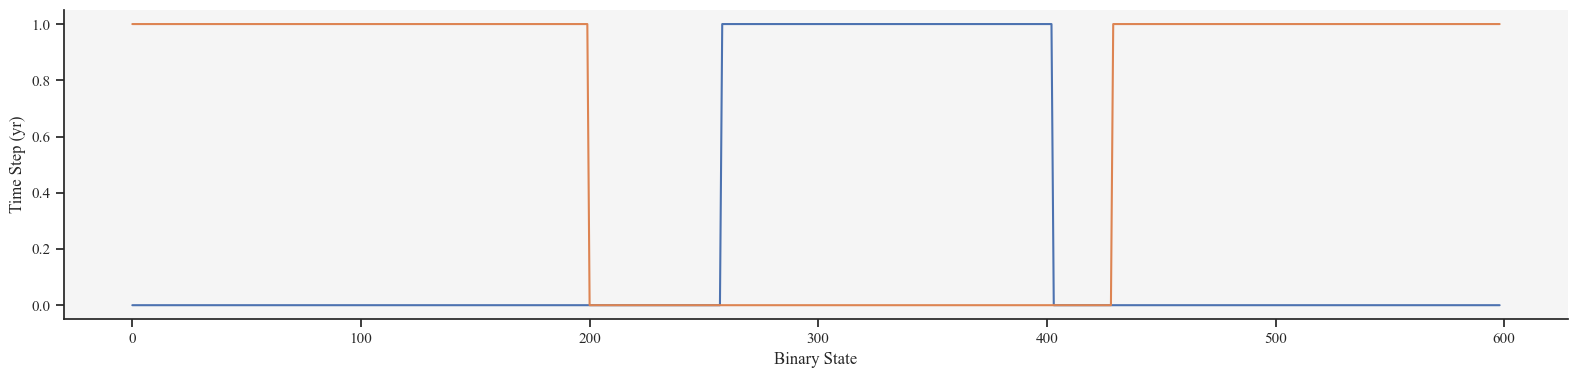

Time to disrupted equilibrium: 189 yr
Time to initial equilibrium: 54 yr


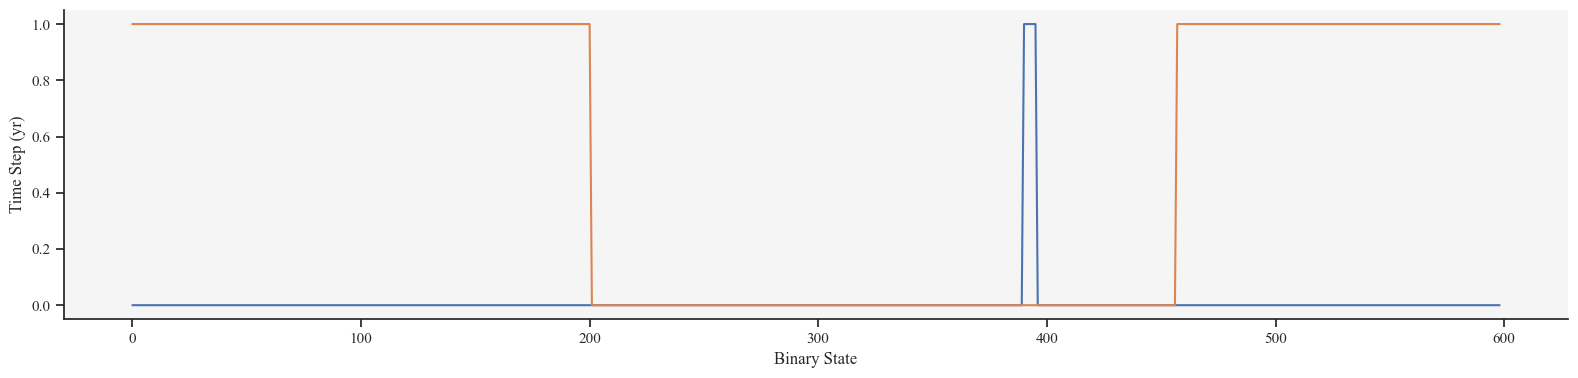

Time to disrupted equilibrium: 21 yr
Time to initial equilibrium: 61 yr


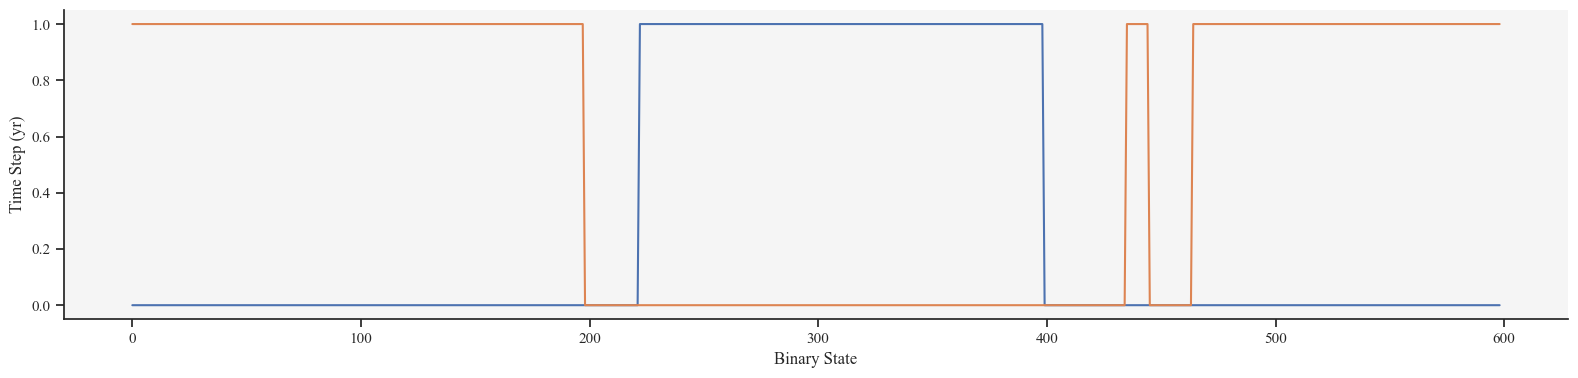

Time to disrupted equilibrium: 23 yr
Time to initial equilibrium: 30 yr


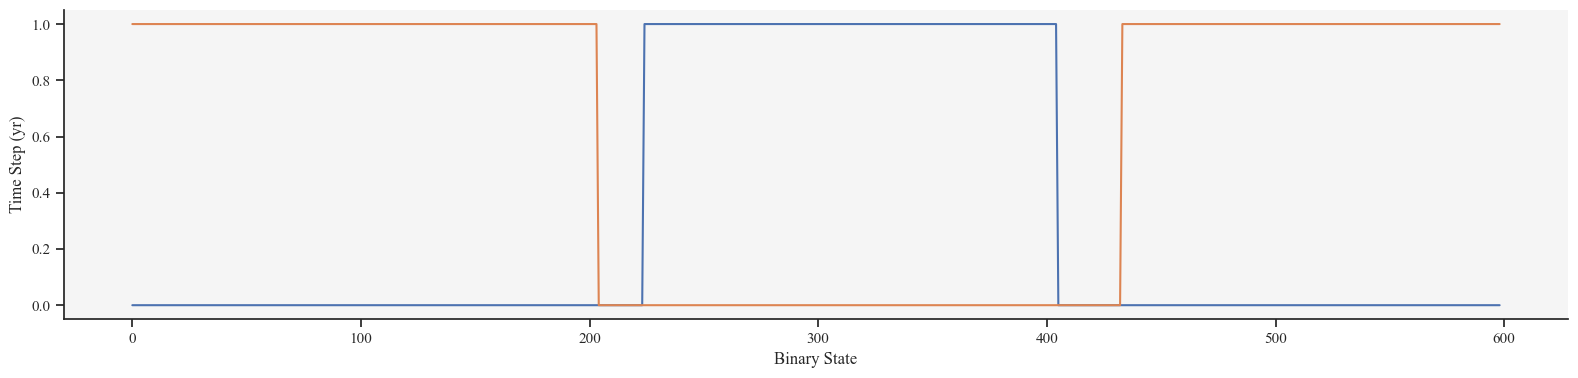

In [25]:
################################
## COMPUTE TIME TO EQUILIBRIA ##
################################

## Trheshold
th = 0.05 # Acceptable difference between recovered and disrupted equilibria in number of individuals
index = 2 # Reference state for determining equilibria

rrecovery_times = []
pperturbation_times = []
for index in [0, 1, 2, 3]:

    ## Perturbation
    perturbation = (torch.abs(TS[:,index] - eq_2[index]) < th * eq_2[index])*1
    perturbation = (((perturbation[1:] + perturbation[0:-1])/2) > 0.5)*1 # Smooth
    perturbation = (((perturbation[1:] + perturbation[0:-1])/2) > 0.5)*1 # Smooth
    perturbation = (((perturbation[1:] + perturbation[0:-1])/2) > 0.5)*1 # Smooth
    perturbation = (((perturbation[1:] + perturbation[0:-1])/2) > 0.5)*1 # Smooth
    if len(np.where(perturbation == 1)[0]) == 0:
        t_perturbation = t_max_2 + t_max_1 + 1
    else:
        t_perturbation = np.where(perturbation == 1)[0][0]
    print(f"Time to disrupted equilibrium: {t_perturbation - (t_max_1 + 1):.0f} yr")
    
    ## Recovery
    recovery = (torch.abs(TS[:,index] - eq_3[index]) < th * eq_3[index])*1
    recovery = (((recovery[1:] + recovery[0:-1])/2) > 0.5)*1 # Smooth
    recovery = (((recovery[1:] + recovery[0:-1])/2) > 0.5)*1 # Smooth
    recovery = (((recovery[1:] + recovery[0:-1])/2) > 0.5)*1 # Smooth
    recovery = (((recovery[1:] + recovery[0:-1])/2) > 0.5)*1 # Smooth
    t_recovery = np.where(recovery == 0)[0][-1]
    print(f"Time to initial equilibrium: {t_recovery - (t_max_1 + t_max_2 + 2):.0f} yr")

    ## Collect
    rrecovery_times += [t_recovery]
    pperturbation_times += [t_perturbation]
    
    ## Visualise
    plt.figure(figsize=(16,4))
    plt.plot(perturbation, label='Perturbation')
    plt.plot(recovery, label='Recovery')
    plt.xlabel('Binary State')
    plt.ylabel('Time Step (yr)')
    plt.tight_layout()
    plt.show()


#
###

In [14]:
print(pperturbation_times)
print(rrecovery_times)

[258, 390, 222, 224]
[428, 456, 463, 432]


<Figure size 1800x1200 with 0 Axes>

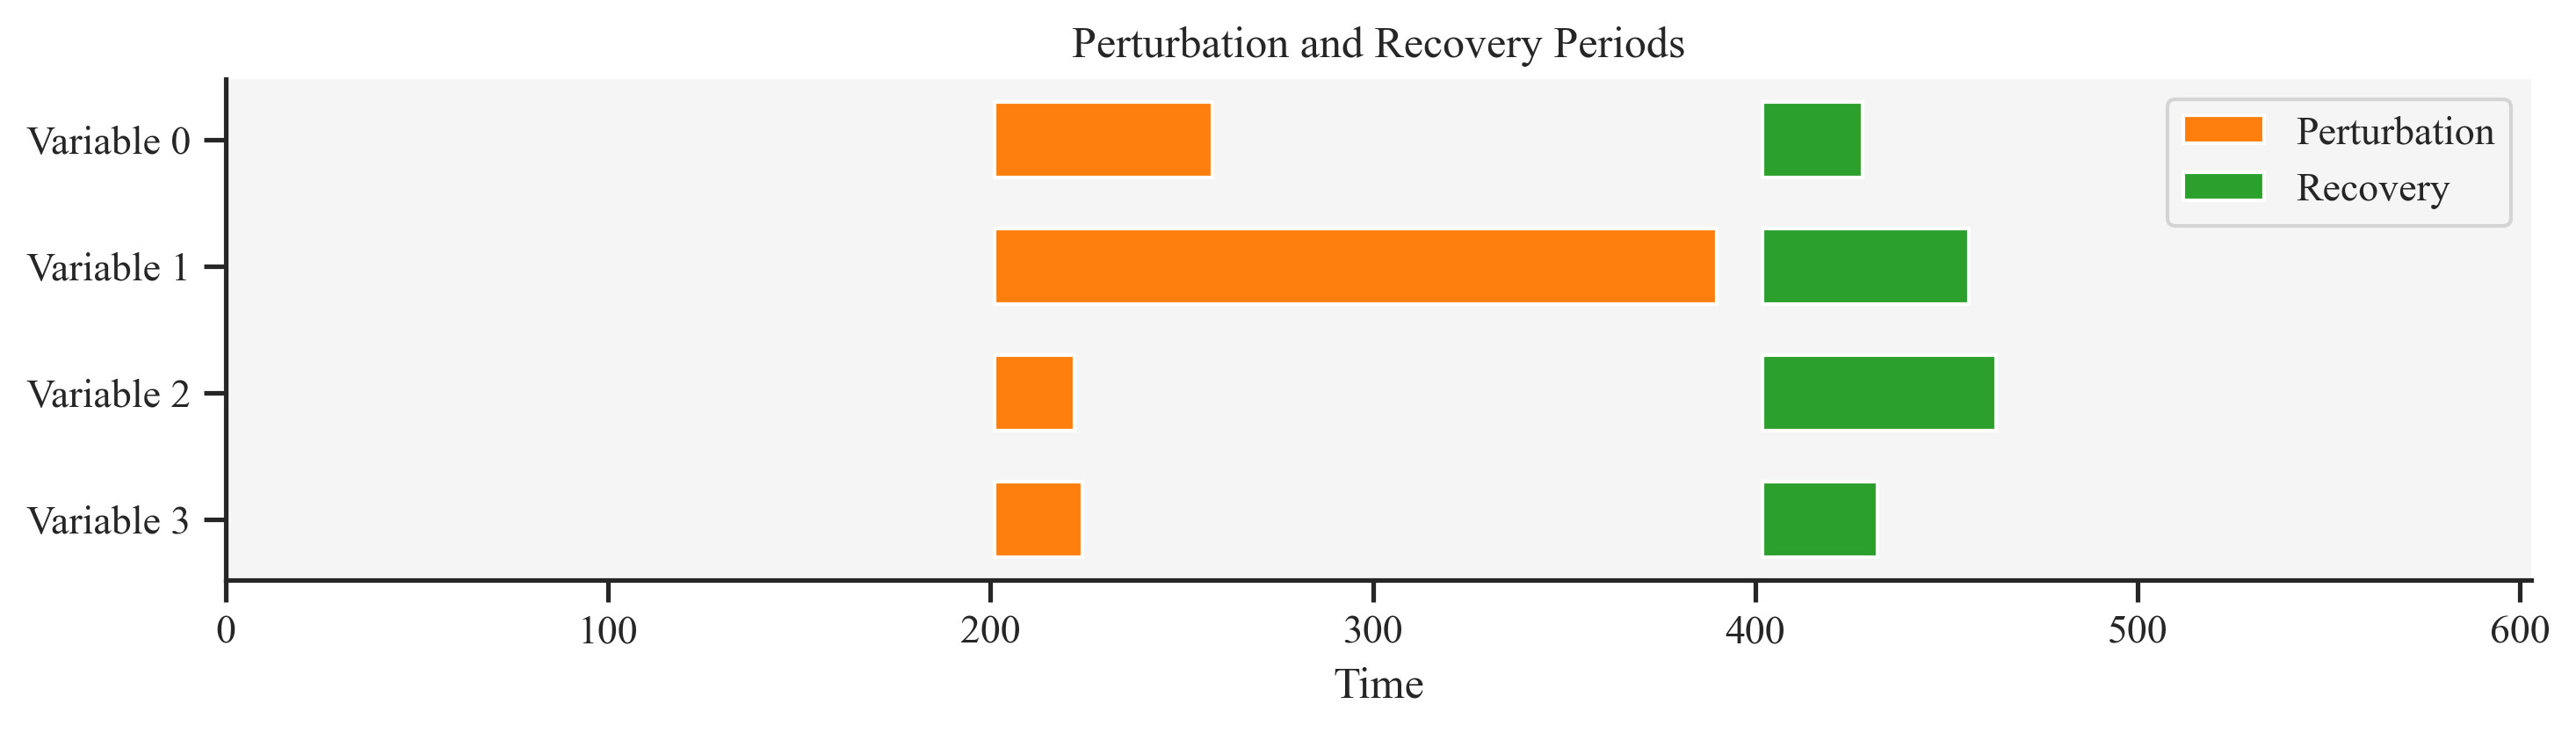

In [15]:
################
## TRANSIENTS ##
################

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=FIGSIZE)
#
starts = {"Perturbation": 201, "Recovery": 402}
ends = {"Perturbation": pperturbation_times, "Recovery": rrecovery_times}
colors = {"Perturbation": "tab:orange", "Recovery": "tab:green"}

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(pperturbation_times)):
    for phase in starts:
        ax.barh(
            i,
            ends[phase][i] - starts[phase],
            left=starts[phase],
            height=0.6,
            color=colors[phase],
            label=phase if i == 0 else ""
        )

ax.set(
    xlim=(0, 603),
    yticks=range(len(pperturbation_times)),
    yticklabels=[f"Variable {i}" for i in range(len(pperturbation_times))],
    xlabel="Time",
    title="Perturbation and Recovery Periods"
)

ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()
#
plt.rcParams['figure.dpi'] = 100

#
###

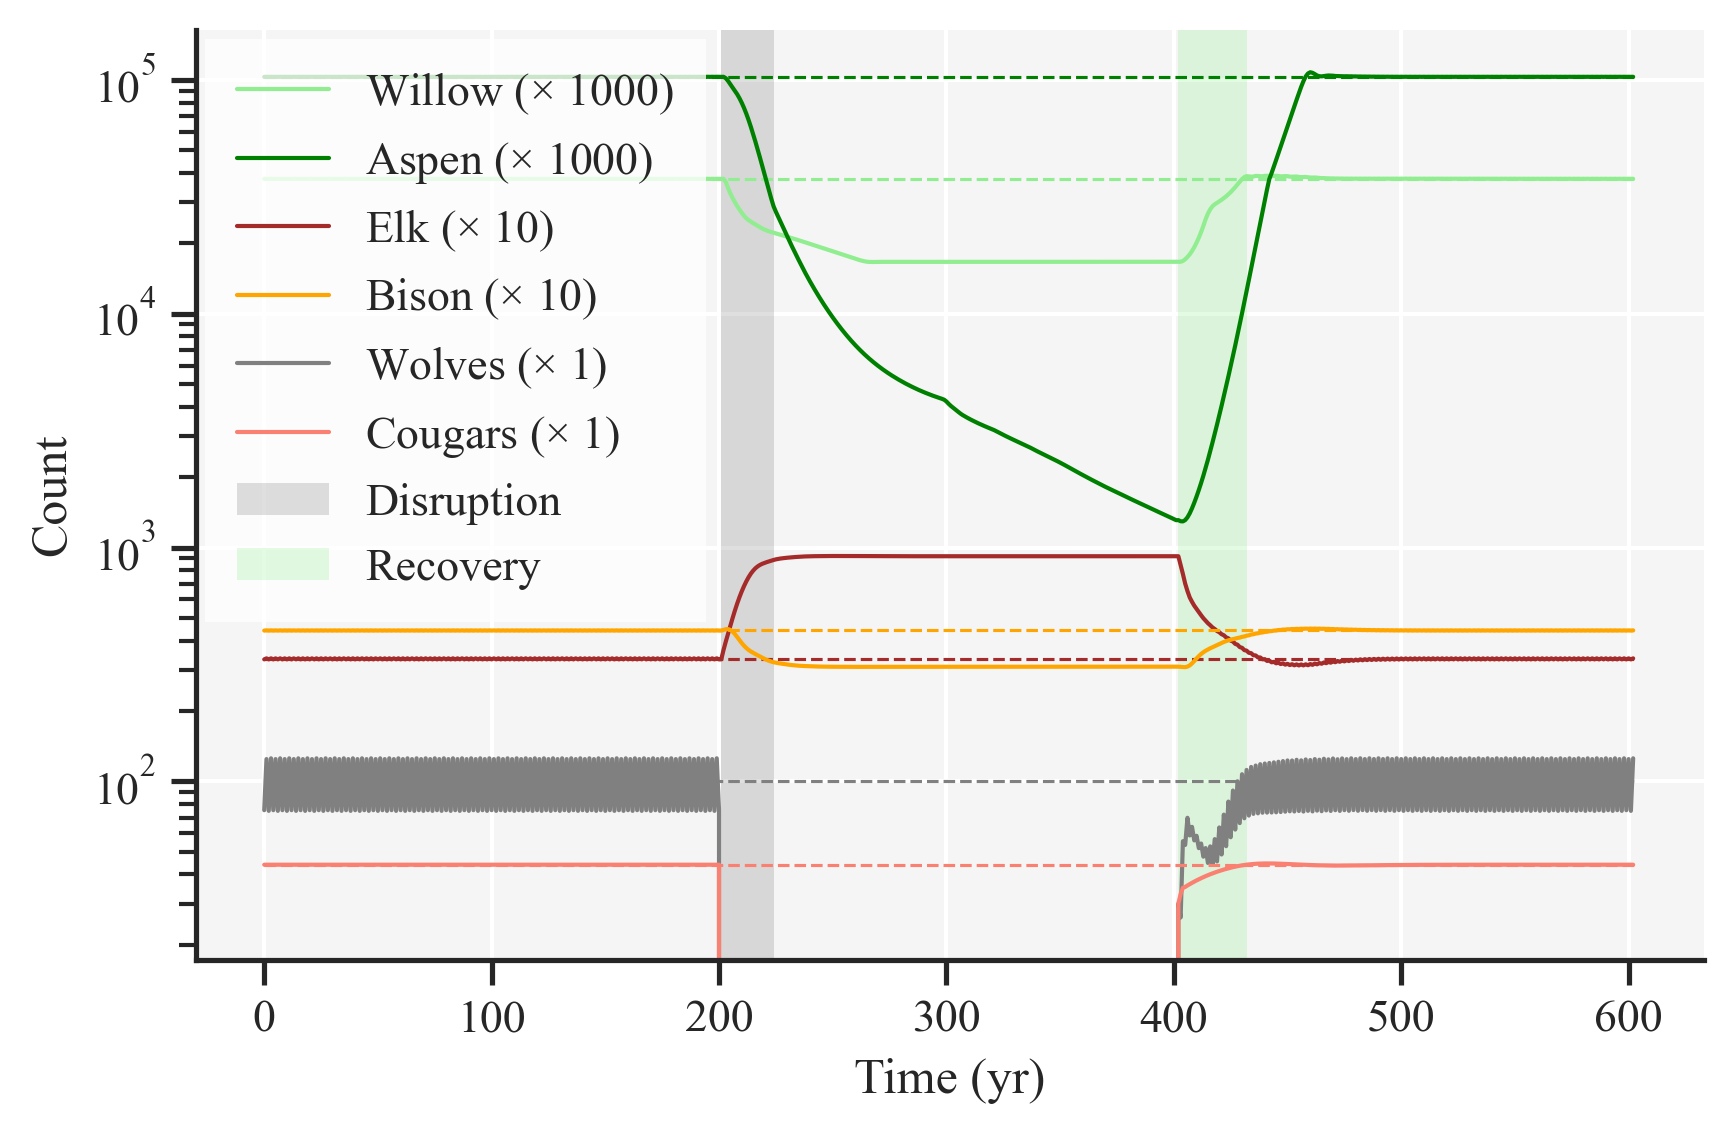

In [16]:
###########################
## VISUALISE EXTIRPATION ##
###########################

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=FIGSIZE)
#
ttimes = np.arange(len(TS))
llabels = ['Willow', 'Aspen', 'Elk', 'Bison', 'Wolves', 'Cougars']
ccolors = ['lightgreen', 'green', 'Brown', 'Orange', 'Grey', 'Salmon']
sscales = [0.001, 0.001, 0.1, 0.1, 1.0, 1.0]
#
for i in range(TS.shape[1]):
    if i >= 0:
        plt.plot(ttimes, TS[:,i] * sscales[i], label=f"{llabels[i]} ($\\times$ {np.round(1/sscales[i]):.0f})", lw=1.0, color=ccolors[i])
        x = [0,len(ttimes)]
        y = torch.mean(TS[0:100,i]) * sscales[i]
        plt.plot(x,[y,y], '--', lw=0.75, color=ccolors[i])
#
plt.axvspan(t_max_1 + 1, t_perturbation, color='grey', alpha=0.25, linewidth=0, label='Disruption')
plt.axvspan(t_max_1 + t_max_2 + 2, t_recovery, color='lightgreen', alpha=0.25, linewidth=0, label='Recovery')
#
plt.xlabel('Time (yr)')
plt.ylabel('Count')
plt.yscale('log')
#
leg = plt.legend(loc='upper left', ncol=1)
frame = leg.get_frame()
frame.set_boxstyle('square')  # removes rounded corners
frame.set_edgecolor('none')   # no border line
frame.set_facecolor('white')
#
plt.grid(color='white')
# plt.title('a.', fontweight='bold', loc='right')
#
plt.tight_layout()
plt.show()
plt.rcParams['figure.dpi'] = 100

#
###

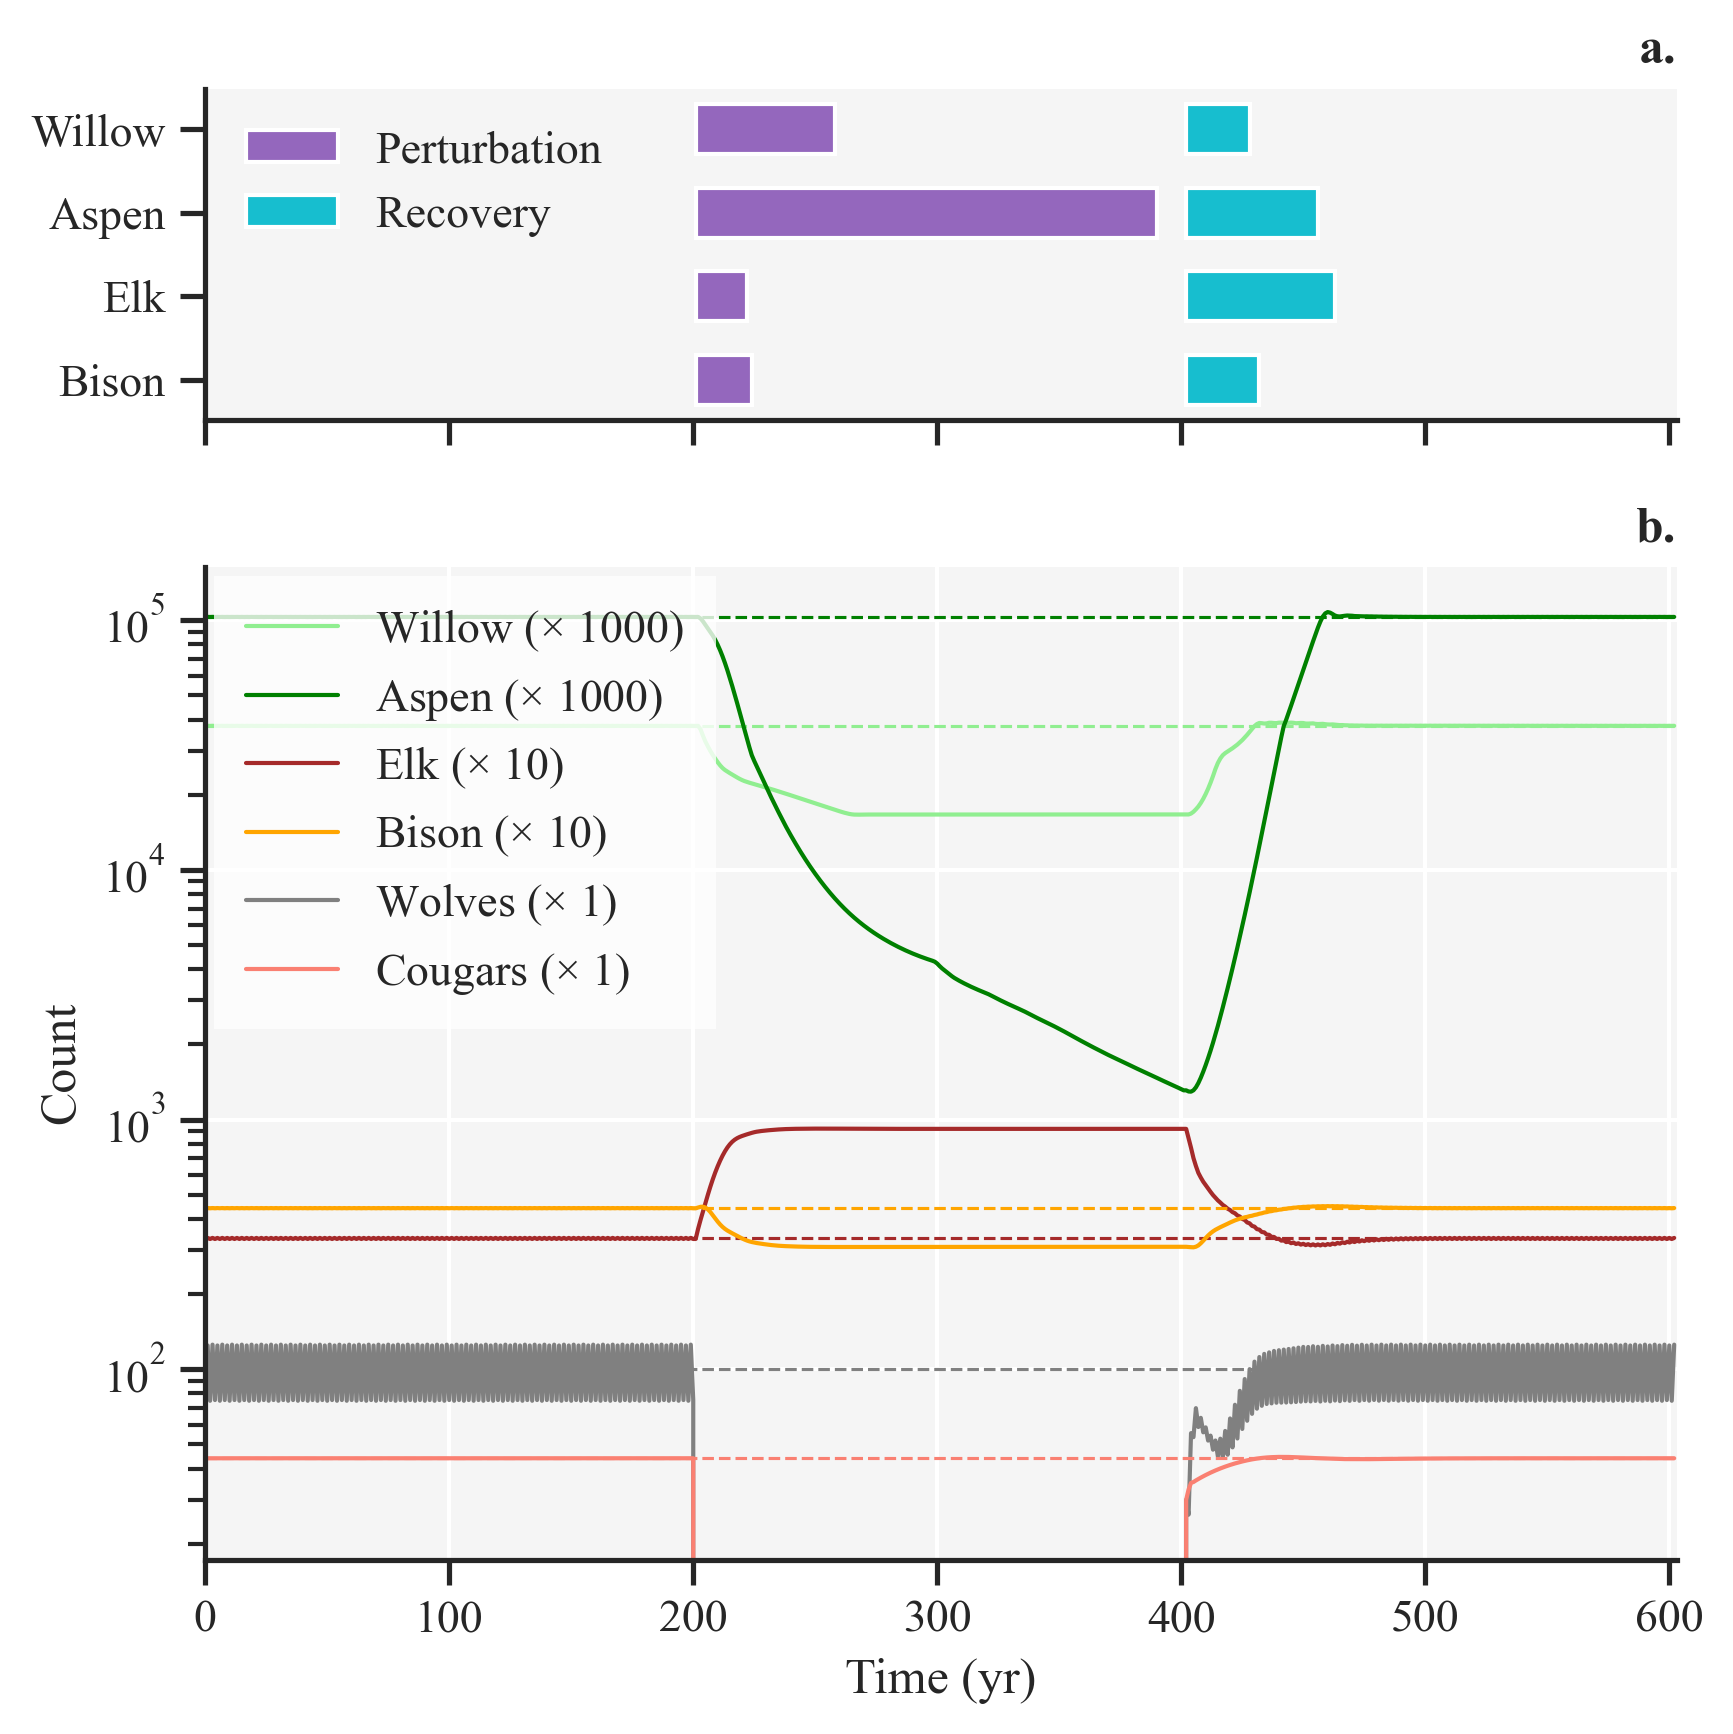

In [23]:
####################
## COMBINED PLOTS ##
####################

plt.rcParams['figure.dpi'] = 300

## Create figure
fig, (ax_timeline, ax_ts) = plt.subplots(
    2, 1,
    figsize=(6,6),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 3]}
)


## Top panel
llabels = ['Willow', 'Aspen', 'Elk', 'Bison', 'Wolves', 'Cougars']
starts = {"Perturbation": 201, "Recovery": 402}
ends = {"Perturbation": pperturbation_times, "Recovery": rrecovery_times}
colors = {"Perturbation": "tab:purple", "Recovery": "tab:cyan"}
#
for i in range(len(pperturbation_times)):
    for phase in starts:
        ax_timeline.barh(
            i,
            ends[phase][i] - starts[phase],
            left=starts[phase],
            height=0.6,
            color=colors[phase],
            label=phase if i == 0 else ""
        )
#
ax_timeline.set(
    yticks=range(len(pperturbation_times)),
    yticklabels=[f"{llabels[i]}" for i in range(len(pperturbation_times))],
    # title="Perturbation and Recovery Periods"
)
#
ax_timeline.set_title('a.', loc='right', fontweight='bold')
ax_timeline.invert_yaxis()
ax_timeline.legend(loc="upper left", frameon=False)
ax_timeline.grid(False)

## Bottom panel
ttimes = np.arange(len(TS))
llabels = ['Willow', 'Aspen', 'Elk', 'Bison', 'Wolves', 'Cougars']
ccolors = ['lightgreen', 'green', 'Brown', 'Orange', 'Grey', 'Salmon']
sscales = [0.001, 0.001, 0.1, 0.1, 1.0, 1.0]
#
for i in range(TS.shape[1]):
    ax_ts.plot(
        ttimes,
        TS[:, i] * sscales[i],
        label=f"{llabels[i]} ($\\times$ {np.round(1/sscales[i]):.0f})",
        lw=1.0,
        color=ccolors[i]
    )

    x = [0, len(ttimes)]
    y = torch.mean(TS[0:100, i]) * sscales[i]
    ax_ts.plot(x, [y, y], '--', lw=0.75, color=ccolors[i])
#
ax_ts.set(
    xlabel='Time (yr)',
    ylabel='Count'
)
ax_ts.set_yscale('log')
#
ax_ts.set_title('b.', loc='right', fontweight='bold')
leg = ax_ts.legend(loc='upper left', ncol=1)
frame = leg.get_frame()
frame.set_boxstyle('square')
frame.set_edgecolor('none')
frame.set_facecolor('white')
#
ax_ts.grid(color='white')

## Final layout
ax_ts.set_xlim(0, 603)
plt.tight_layout()
plt.show()

plt.rcParams['figure.dpi'] = 100

#
###

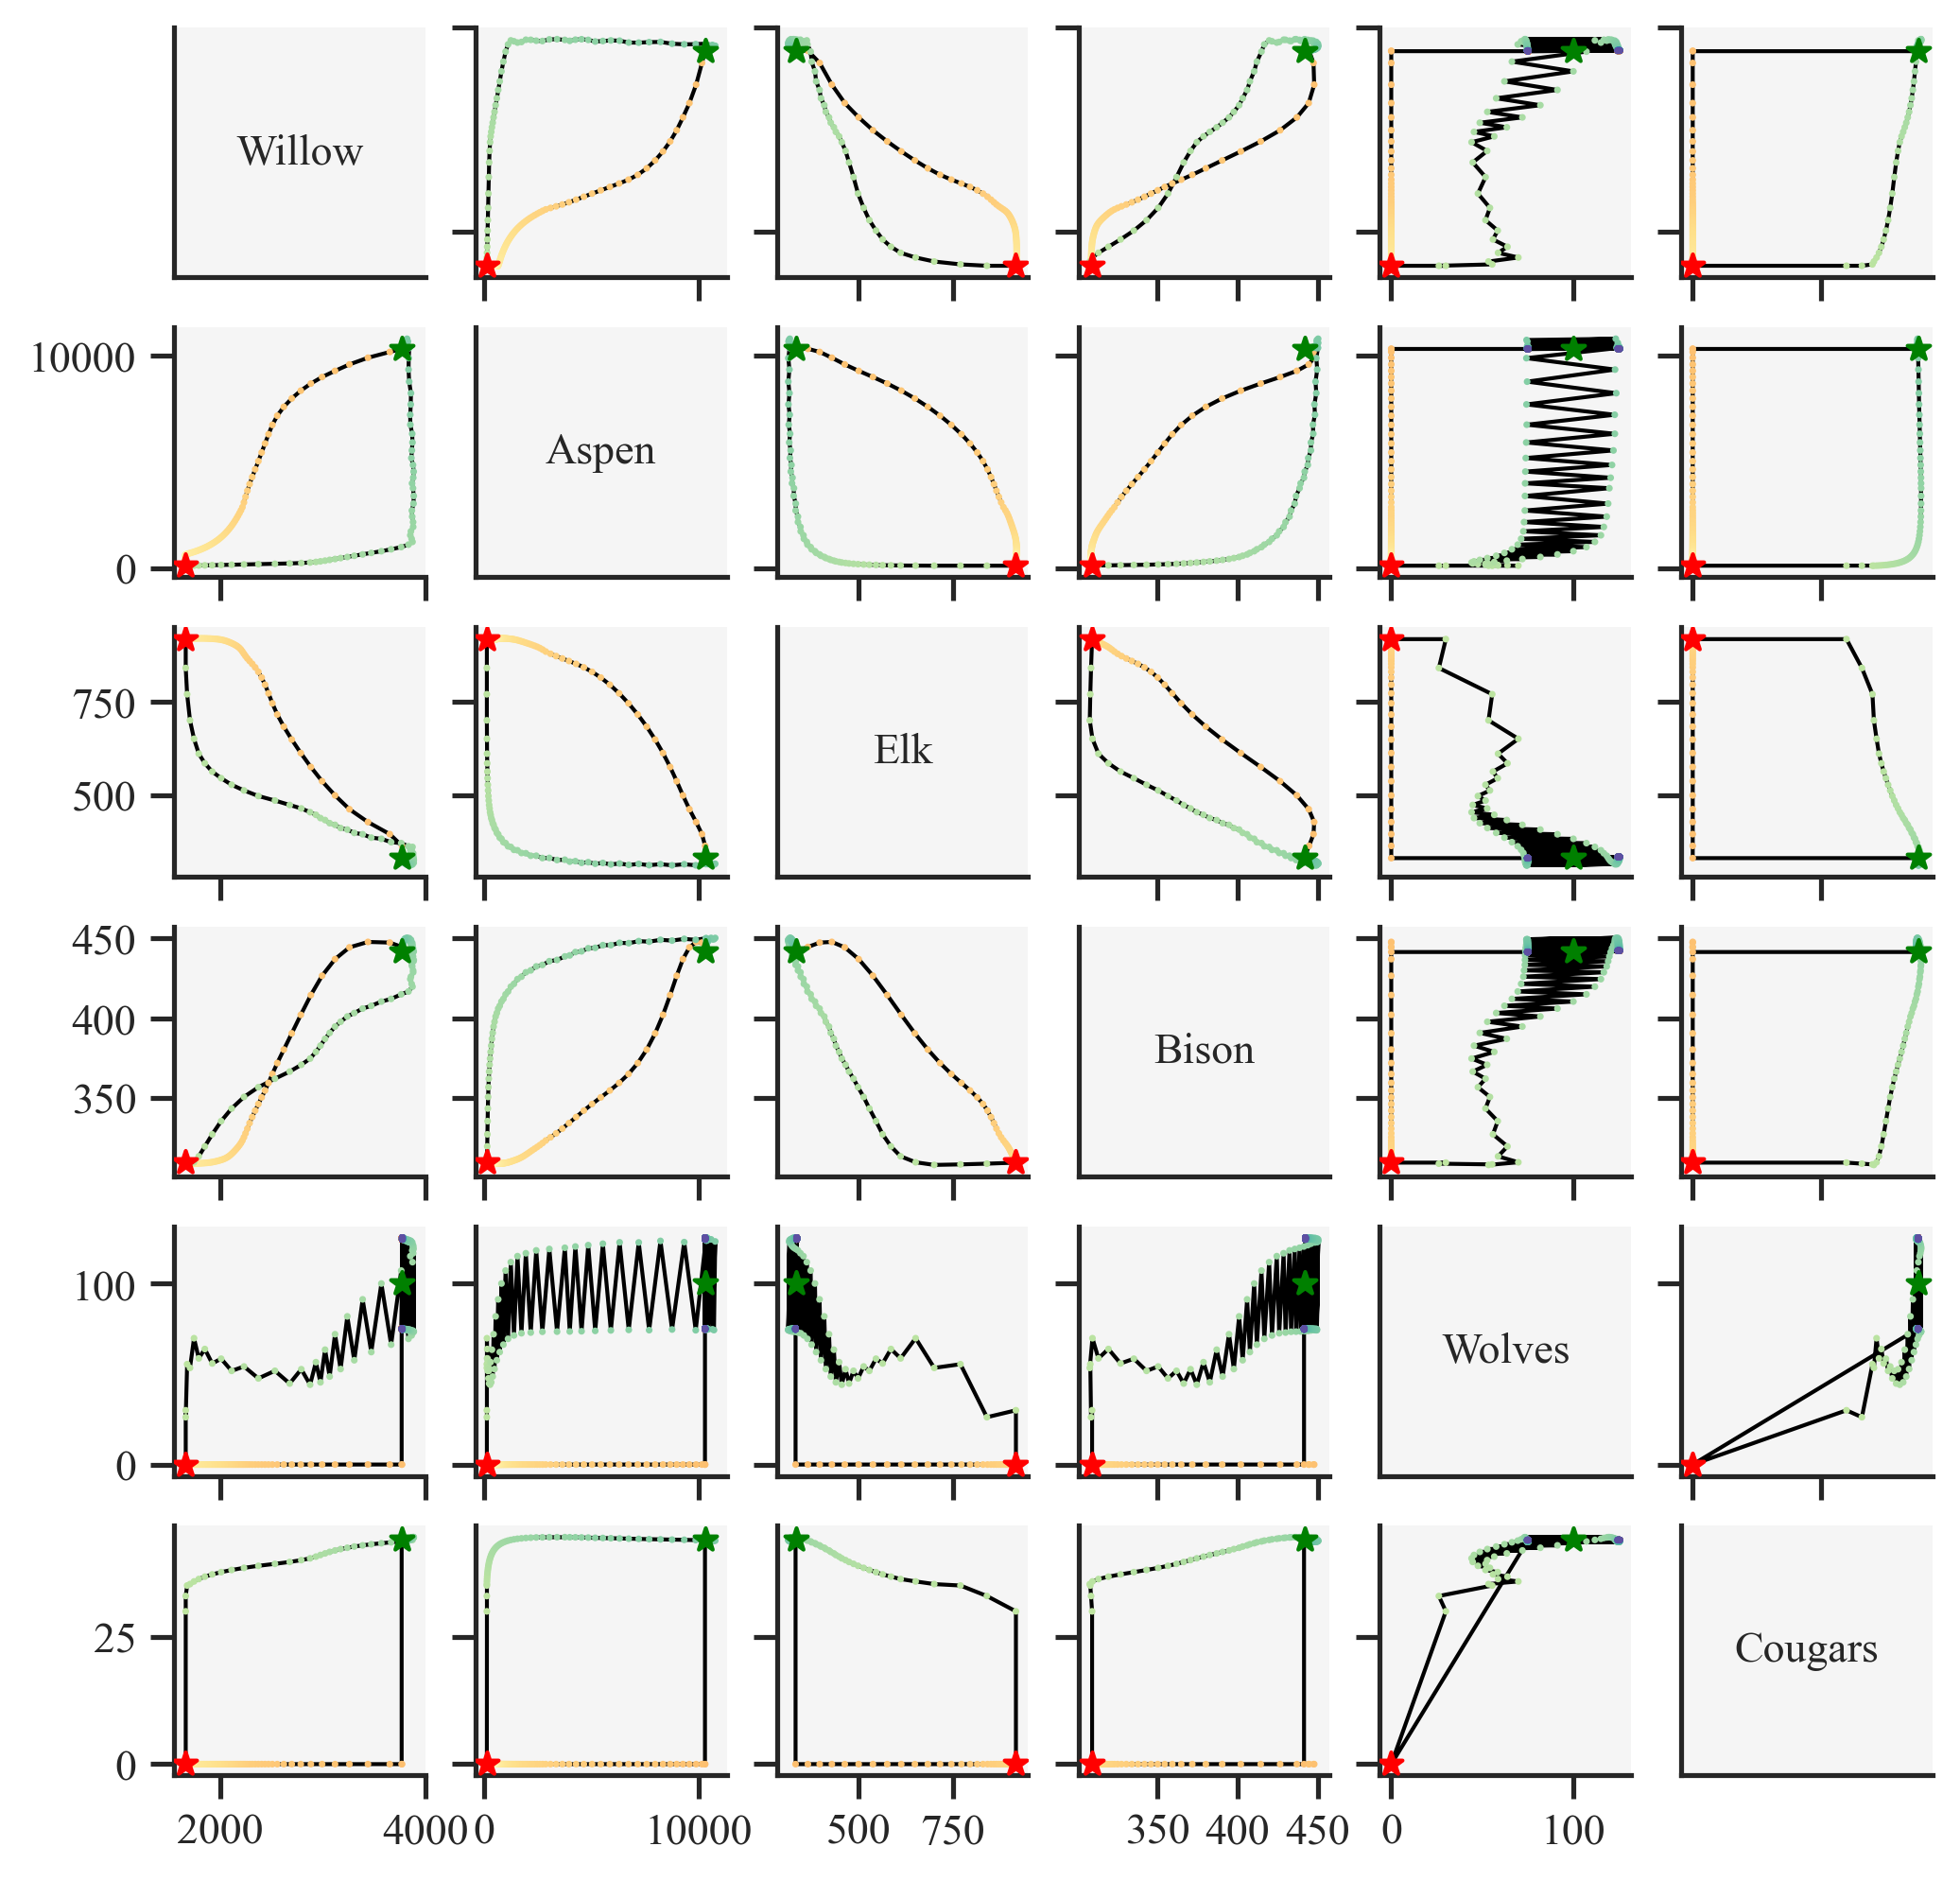

In [24]:
###################
## VISUALISATION ##
###################

plt.rcParams['figure.dpi'] = 300
ttimes = np.arange(len(TS))
llabels = ['Willow', 'Aspen', 'Elk', 'Bison', 'Wolves', 'Cougars']
ccolors = ['Red', 'Blue', 'Brown', 'Orange', 'Grey', 'Salmon']
sscales = [0.0001, 0.0001, 0.1, 0.1, 1.0, 1.0]
ccolors = np.linspace(0, 1, TS.shape[0])

n = TS.shape[1]
fig, axes = plt.subplots(n, n, figsize=(8,8), dpi=300)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        
        if i != j:
            ax.plot(TS[:, j] * sscales[j], TS[:, i] * sscales[i],
                    lw=1.0, color='black')
            ax.scatter(TS[:, j] * sscales[j], TS[:, i] * sscales[i],
                       c=ccolors, cmap='Spectral', s=0.5, zorder=2)
            ax.scatter(eq_1[j] * sscales[j], eq_1[i] * sscales[i],
                       color='green', zorder=3, marker='*')
            ax.scatter(eq_2[j] * sscales[j], eq_2[i] * sscales[i],
                       color='red', zorder=3, marker='*')
        else:
            if i == j:
                # Remove only the ticks, keep the box (spines)
                ax.set_xticks([])
                ax.set_yticks([])
                # Optional: add label text in the middle
                ax.text(0.5, 0.5, llabels[i], fontsize=11, ha='center', va='center', transform=ax.transAxes)
            # else:
            #     ax.text(0.5, 0.5, llabels[i], fontsize=11, ha='center', va='center', color='white')
            #     ax.axis('off')
        
        # Hide inner tick labels (keep ranges consistent)
        if i < n - 1:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])
        
        # Optionally add small tick marks even if labels are hidden
        ax.tick_params(axis='x', which='both', bottom=True, top=False)
        ax.tick_params(axis='y', which='both', left=True, right=False)

# Adjust spacing for visibility
# plt.tight_layout()
plt.show()
plt.rcParams['figure.dpi'] = 100

#
###

In [ ]:
"""
###################
## VISUALISATION ##
###################

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,6))
#
ttimes = np.arange(len(TS))
llabels = ['Willow', 'Aspen', 'Elk', 'Bison', 'Wolves', 'Cougars']
ccolors = ['Red', 'Blue', 'Brown', 'Orange', 'Grey', 'Salmon']
sscales = [0.0001, 0.0001, 0.1, 0.1, 1.0, 1.0]
ccolors = np.linspace(0, 1, TS.shape[0])
#
k = 0
for i in range(TS.shape[1]):
    for j in range(TS.shape[1]):
        plt.subplot(TS.shape[1],TS.shape[1],k+1)
        if i != j:
            plt.plot(TS[:,j] * sscales[j], TS[:,i] * sscales[i], label=f"{llabels[i]} ($\\times$ {np.round(1/sscales[i]):.0f})", lw=1.0, color='black')
            plt.scatter(TS[:,j] * sscales[j], TS[:,i] * sscales[i], c=ccolors, cmap='Spectral', s=0.5, zorder=2)
            plt.scatter(eq_1[j] * sscales[j], eq_1[i] * sscales[i], color='green', zorder=3, marker='*')
            plt.scatter(eq_2[j] * sscales[j],eq_2[i] * sscales[i], color='red', zorder=3, marker='*')
        else:
            plt.text(0.5, 0.5, llabels[i], fontsize=11, ha='center', va='center')
        #        
        # if (i < j):
        plt.xticks([])  # Removes x-axis ticks and labels
        plt.yticks([])  # Removes y-axis ticks and labels
        #
        k += 1
#
# plt.tight_layout()
plt.show()
plt.rcParams['figure.dpi'] = 100

#
###
"""